### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [3]:
from data.crypto_data_loader import load_multi_symbol_data, DataHandler

from model.feature_generator import FeatureGenerator, FeatureProcessor
from model.fit_pred import split_data, clean_xy, fit_predict_regression_model, score_reg_pred
from model.model_evaluator import RegressionEvaluator
from model.signal_generator import SignalGenerator
from model.timeseries_cv import MultipleTimeSeriesCV

from streamlit_app.plot_signals import plot_signals, plot_recent_signals

from backtest.strategies import AtrDynamicStopStrategy, AtrLongOnlyStrategy
from backtest.backtest import run_backtest, print_bt_evals, extract_trades_df, plot_pnl_curve

handler = DataHandler()
reg_eval = RegressionEvaluator()

### Configs

In [4]:
# data symbols
target = 'ETHUSDT'
load_symbols = ['BTCUSDT', 'ETHUSDT','SOLUSDT','DOGEUSDT']

In [ ]:
INTERVAL = '30m'
START_DELTA = timedelta(days=60)
# DB_PATH = 'data/crypto_data.db'
MODEL_NAME = 'rf-reg'
STRATEGY_NAME = 'zscore_atr_v1'
target_col = 'target_1h'

target_cols = ['target_1h','target_2h','target_4h','target_12h']

In [5]:
# feature engineering params
feature_config = {
    "other_symbols": ['BTCUSDT', 'ETHUSDT','SOLUSDT','DOGEUSDT'],
    "lags": [1, 2, 4, 12, 24, 48, 72], # lags must contain rt_targets
    "rt_targets": [1, 2, 4, 12, 24],
    "vol_window": 24,
    "rsi_window": 12,
    "mfi_window": 12,
    "bb_window": 24,
    "tema_windows": [12,24,36],
    "adx_window": 12,
    "cmo_window": 12,
    "ulti_os_windows": {
            'period1':8,
            'period2':12,
            'period3':24
        },
    "patterns": {
            'CDLENGULFING': '吞没形态',
            'CDLHAMMER': '锤子线',
            'CDLHANGINGMAN': '吊人线',
            'CDLDOJI': '十字星',
            'CDLDRAGONFLYDOJI': '蜻蜓十字星',
            'CDLGRAVESTONEDOJI': '墓碑十字星',
            'CDLMORNINGSTAR': '晨星',
            'CDLEVENINGSTAR': '暮星',
            'CDLSHOOTINGSTAR': '流星',
            'CDLMARUBOZU': '光头光脚'
        }
}

# cols to scale and drop
feature_process_config = {
    'metrics_to_scale': ["high", "low", "close"],
    'cols_to_drop': ["open","high","low","close","volume","dollar_vol","hour",
                "atr","macdhist",'hour_bin_label','cmo','tema_12','tema_24','tema_36']
}

In [ ]:
# cv
tscv = MultipleTimeSeriesCV(
        train_length=24 * 7 * 4,
        test_length=1,
        lookahead=1,
        date_idx='datetime'
    )

# model
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(
    n_estimators=300,
    min_samples_leaf=5,
    max_features='sqrt',
    max_depth=15,
    random_state=42,
    n_jobs=-1)

train_model = reg_rf

In [7]:
# signal filter params
signal_config = {
    'z_window': 24,
    'z_threshold': 1,
    'atr_windows': {
        'short': 4,
        'long': 24
    },
    'atr_threshold': 0.9
}

### Load data from API

In [ ]:
model_start_date = (datetime.utcnow() - START_DELTA).strftime('%Y-%m-%d %H:%M:%S')
print(model_start_date)

df_price = load_multi_symbol_data(handler=handler, 
                                  symbols=load_symbols, 
                                  interval=INTERVAL, 
                                  start_str=model_start_date)

2025-06-22 20:59:37


### Feature Engineering

In [201]:
df_features = (
        FeatureGenerator(config=feature_config)
        .load_data(df=df_price)
        .select_symbols(target_symbol=target)
        .compute_volume_features()
        .compute_momentum_features()
        .compute_volatility_features()
        .compute_target_cols()
        .compute_time_dummies()
        .compute_tech_indicators()
        .compute_candle_patterns()
        .get_single_symbol_data(target_symbol=target)
    )

df_processed = (
        FeatureProcessor(config=feature_process_config)
        .load_data(df=df_features)
        .scale_metrics()
        .drop_cols()
        .df
    )

### Fit predict

In [202]:
X, y = split_data(df_processed)
X_clean, y_clean = clean_xy(X, y[target_col])
pred_df = fit_predict_regression_model(train_model, X_clean, y_clean, cv=tscv)

### Parameter Tuning

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr
from sklearn.model_selection import TimeSeriesSplit

# ---------- 自定义评分函数：Spearman IC ----------
def spearman_ic_score(y_true, y_pred):
    try:
        return spearmanr(y_true, y_pred)[0]  # 返回 rho
    except:
        return np.nan  # 防止某一天全是NA或常数导致报错

ic_scorer = make_scorer(spearman_ic_score, greater_is_better=True)

# ---------- 参数空间 ----------
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_leaf': [3, 5, 7]
}

# ---------- 建模准备 ----------
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=5)

# ---------- RandomizedSearchCV ----------
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # 可调小一点加快速度
    cv=tscv,
    scoring=ic_scorer,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

# ---------- 执行搜索 ----------
random_search.fit(X_clean, y_clean)

# ---------- 提取结果 ----------
results_df = pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score', ascending=False)
print(results_df)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       37.817037     21.425502         1.763581        0.772788   
7       25.849404     10.671468         3.887549        0.612675   
13      39.489780     19.393182         3.836599        1.287137   
6       30.778993     14.855975         4.036327        1.023942   
18      86.046936     29.851527         2.402726        2.096752   
12      19.456300      6.667463         2.947322        0.208248   
5       71.032186     42.146102         3.231018        0.948374   
10      38.994554     17.265217         3.640548        0.704214   
14     177.762883     98.536818         2.988817        1.185789   
17      58.710440     27.326460         3.665887        0.856051   
1       42.006643     20.587148         0.795418        0.034467   
15      32.547864     14.138946         2.989615        0.117033   
0       89.771995     56.739441         1.741582      

### Pred Evaluation

In [203]:
score_df = score_reg_pred(pred_df)
pred_all = pred_df.join(y, how='left')
reg_eval.overall_ic(pred_all)

Information Coefficient (overall): -5.579% (p-value: 8.4232%)


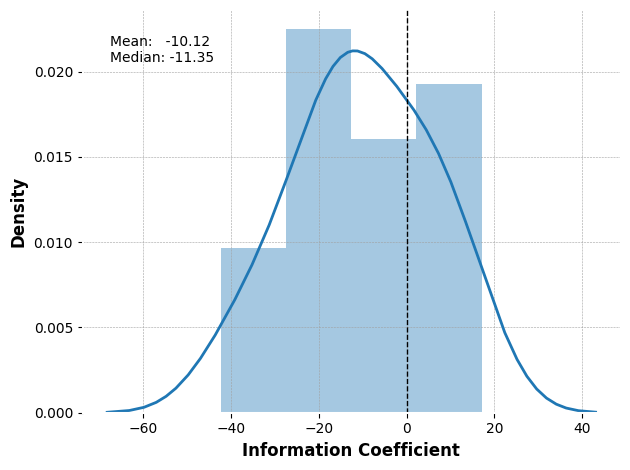

In [204]:
reg_eval.plot_ic_distribution(score_df)

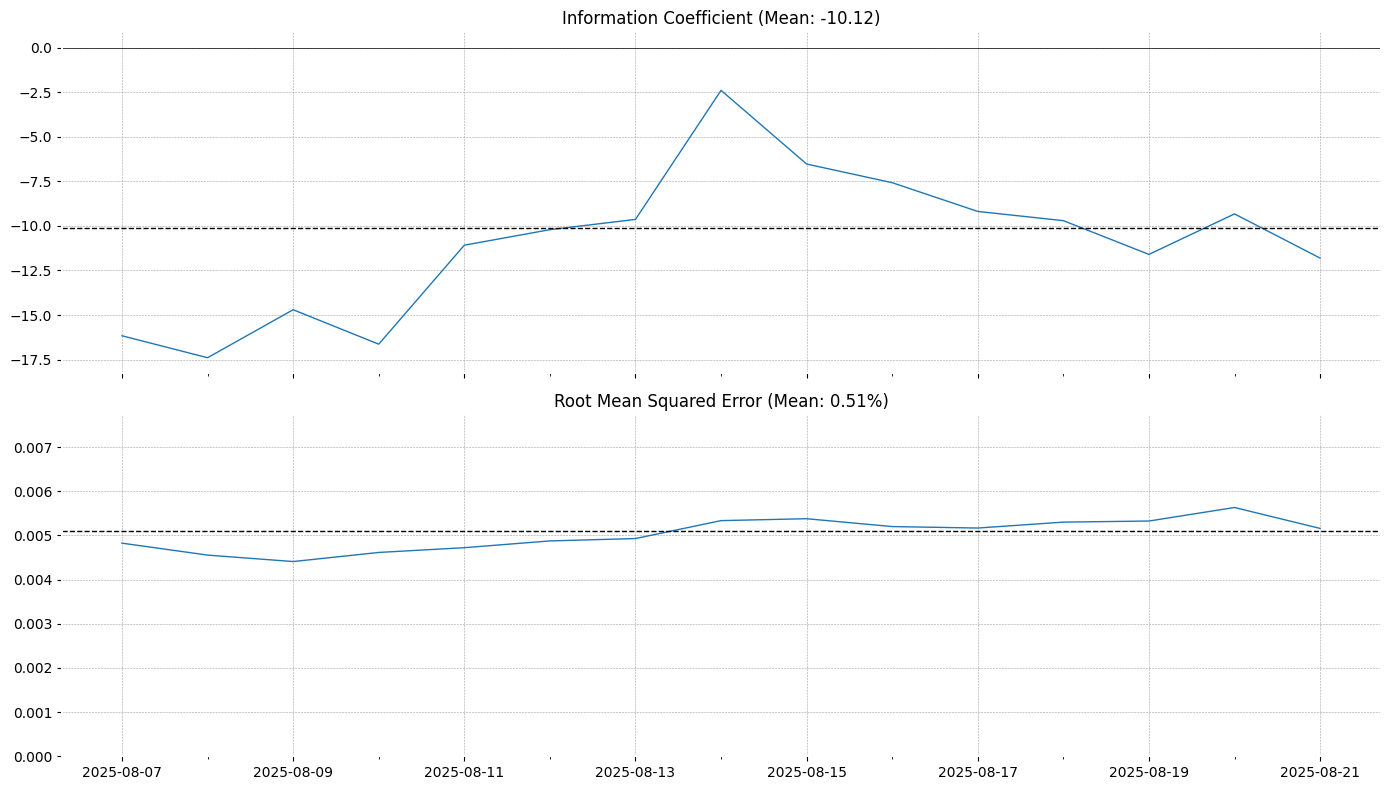

In [205]:
reg_eval.plot_rolling_ic(score_df)

In [206]:
rt_stats = reg_eval.compute_return_stats_by_quantile(pred_df_all=pred_all,
                                                        target_cols=target_cols)
print(rt_stats)

             target_1h                     target_2h                      \
                  mean    median       std      mean    median       std   
quantile                                                                   
1         7.174258e-04  0.000666  0.005187  0.001010  0.001711  0.006816   
2        -7.162438e-08  0.000106  0.004404  0.000109 -0.000013  0.007047   
3         1.812580e-04  0.000276  0.004869  0.000577  0.000860  0.006870   
4        -1.014120e-04 -0.000048  0.005637 -0.000097 -0.000718  0.007310   

         target_4h                     target_12h                      
              mean    median       std       mean    median       std  
quantile                                                               
1         0.001409  0.001400  0.009448   0.002536  0.003105  0.015187  
2         0.000985  0.000853  0.008964   0.002954  0.002847  0.017268  
3         0.000591  0.000531  0.010019   0.004140  0.002990  0.017679  
4         0.000353  0.000285  0.009

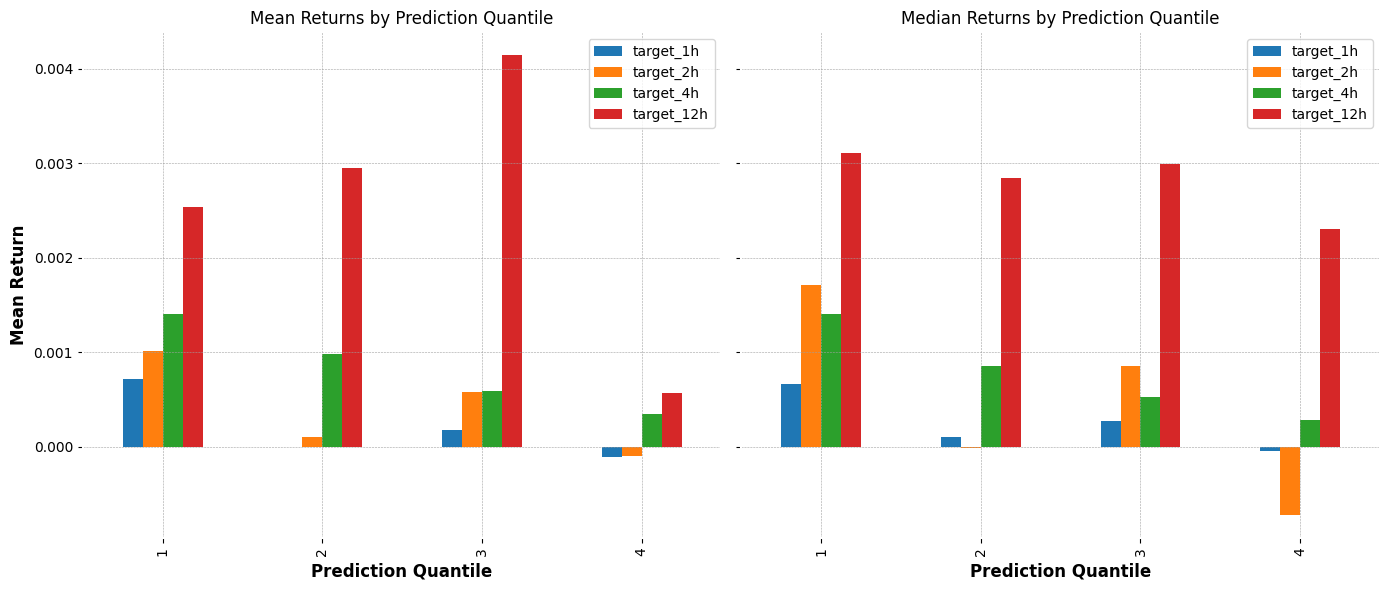

In [207]:
reg_eval.plot_return_stats_by_quantile(rt_stats)

<Figure size 1200x600 with 0 Axes>

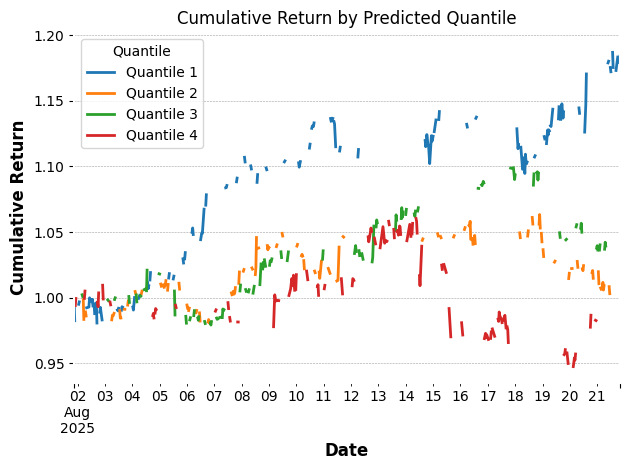

In [208]:
reg_eval.plot_cumulative_returns_by_quantile(pred_df=pred_df, n_bins=4)

       target  long_mean  short_mean    spread
0   target_1h  -0.000101    0.000717 -0.000819
1   target_2h  -0.000097    0.001010 -0.001107
2   target_4h   0.000353    0.001409 -0.001056
3  target_12h   0.000571    0.002536 -0.001965


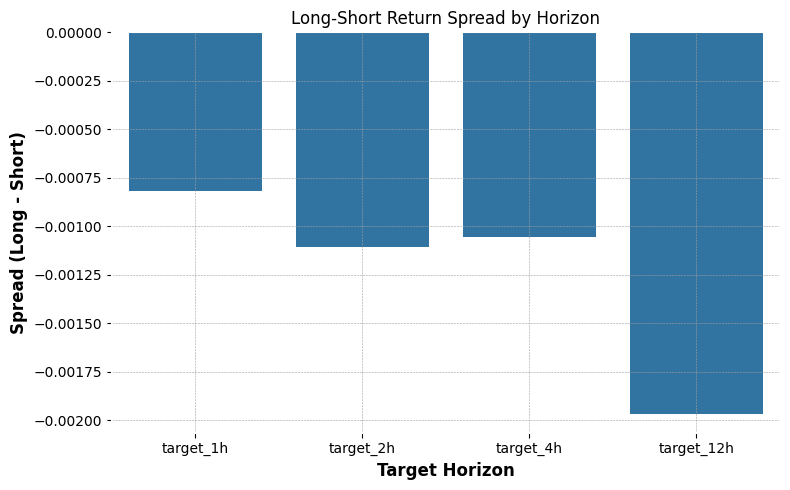

In [209]:
spread_df = reg_eval.compute_long_short_spread(pred_df_all=pred_all, 
                                               target_cols=target_cols, 
                                               n_quantiles=4)
print(spread_df)

reg_eval.plot_long_short_spread(spread_df)

### signals

In [257]:
df_signal = (
        SignalGenerator(config=signal_config)
        .load_data(pred_df=pred_df, price_df=df_price)
        .merge_pred_price(target_symbol=target)
        .zscore_normalize()
        .compute_raw_signal()
        .apply_atr_volatility_filter()
        .compute_positions()
        .compute_reversals()
        .apply_min_signal_spacing(min_space=2)
    )

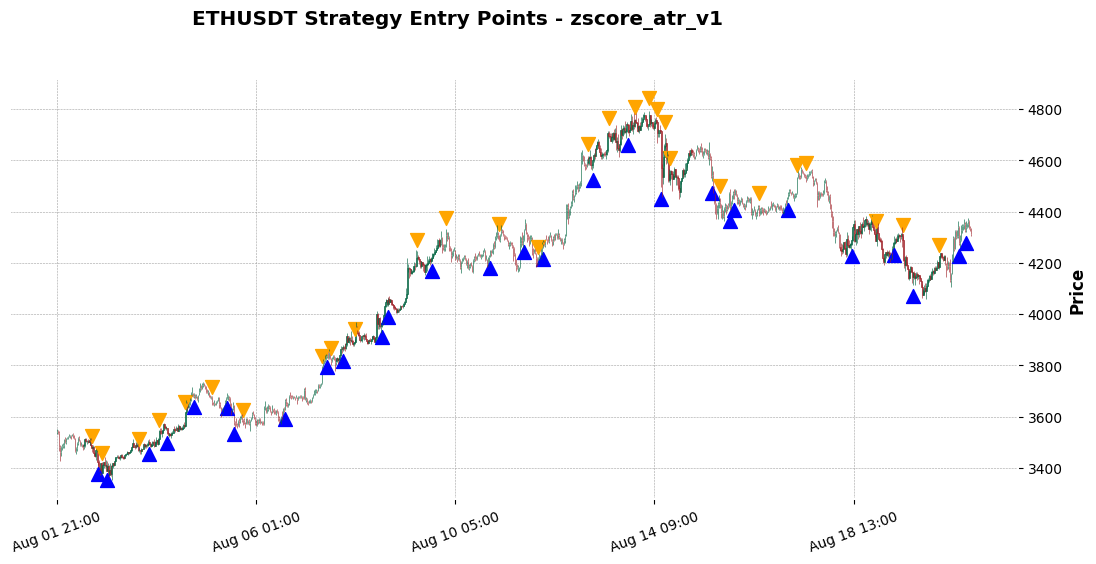

In [258]:
plot_signals(df=df_signal, start='2025-08-01', end='2025-08-21', symbol=target, strategy_name=STRATEGY_NAME)

### Backtest

#### ATR Dynamic

In [330]:
strategy_params = dict(
        atr_period=6,
        atr_tp_factor=1.5,
        atr_sl_factor=3,
        signal_column='final_signal'
    )

In [331]:
results = run_backtest(strategy_class=AtrDynamicStopStrategy,
             signals_df=df_signal, 
             strategy_params=strategy_params,
             )

2025-08-02T14:30:00 - 开空仓 @ 3478.00 (TP=3443.59, SL=3546.82)
2025-08-02T16:00:00 - 空头止盈 @ 3443.59
2025-08-02T17:30:00 - 开多仓 @ 3422.85 (TP=3470.33, SL=3327.89)
2025-08-02T19:30:00 - 反转做空：平多仓 @ 3381.35
2025-08-02T22:00:00 - 开多仓 @ 3389.47 (TP=3440.24, SL=3287.92)
2025-08-03T02:30:00 - 多头止盈 @ 3440.24
2025-08-03T14:30:00 - 开空仓 @ 3470.54 (TP=3443.35, SL=3524.92)
2025-08-03T19:30:00 - 反转做多：平空仓 @ 3495.32
2025-08-03T20:00:00 - 订单失败：Margin
2025-08-04T00:30:00 - 开空仓 @ 3543.90 (TP=3506.91, SL=3617.88)
2025-08-04T04:30:00 - 反转做多：平空仓 @ 3538.21
2025-08-04T05:00:00 - 订单失败：Margin
2025-08-04T13:30:00 - 开空仓 @ 3619.62 (TP=3582.54, SL=3693.79)
2025-08-04T16:30:00 - 空头止损 @ 3693.79
2025-08-04T18:00:00 - 开多仓 @ 3686.92 (TP=3725.96, SL=3608.85)
2025-08-04T21:00:00 - 多头止盈 @ 3725.96
2025-08-05T03:00:00 - 开空仓 @ 3656.31 (TP=3625.16, SL=3718.62)
2025-08-05T07:30:00 - 空头止盈 @ 3625.16
2025-08-05T10:30:00 - 开多仓 @ 3680.92 (TP=3714.55, SL=3613.66)
2025-08-05T12:30:00 - 多头止损 @ 3613.66
2025-08-05T14:00:00 - 开多仓 @ 3579.00 (T

In [332]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.2862669116625866
Max Drawdown: 5.02%
Total Return: 13.37%, Annual Return: 397.44%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 43, 'open': 0, 'closed': 43})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 8)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      18480.349999999973),
                                                     ('average',
                                                      429.7755813953482)])),
                                   ('net',
      

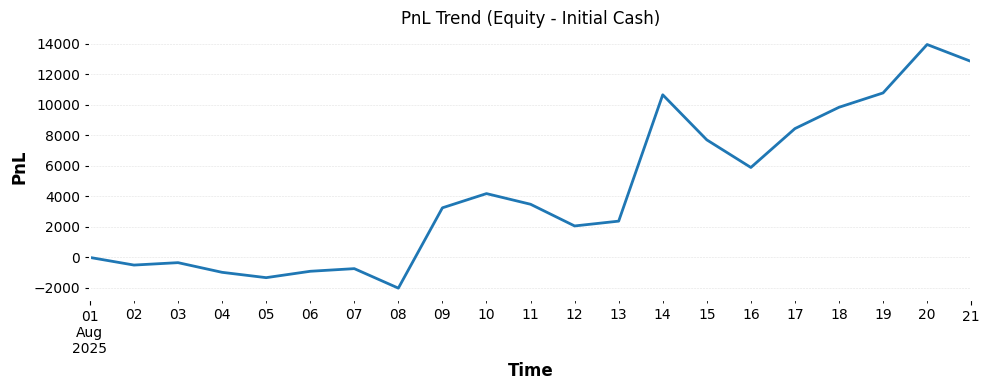

In [317]:
bt_strat = results[0]
trades_df = extract_trades_df(bt_strat)
plot_pnl_curve(bt_strat, initial_cash=100000)